**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Visualize the data](#toc1_2_)    
- [Transfer Learning](#toc2_)    
  - [Prepare Data](#toc2_1_)    
  - [Features Extraction Method (faster but no augmentation)](#toc2_2_)    
    - [Define ResNet Model](#toc2_2_1_)    
    - [Extract features from ResNet](#toc2_2_2_)    
    - [New model](#toc2_2_3_)    
    - [Train](#toc2_2_4_)    
  - [Fine-Tuning method (slower but with augmentation)](#toc2_3_)    
    - [Prepare Data](#toc2_3_1_)    
    - [Create model](#toc2_3_2_)    
- [Tuning Method (unfreeze few layers from ResNet)](#toc3_)    
- [Conclusion](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [91]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torchvision import models, transforms, datasets
from tqdm import tqdm

torch.cuda.is_available()

True

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <a id='toc1_2_'></a>[Visualize the data](#toc0_)

In [94]:
def plot_accuracy_from_history(*histories, labels=None) -> None:
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history['accuracy']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

# <a id='toc2_'></a>[Transfer Learning](#toc0_)

## <a id='toc2_1_'></a>[Prepare Data](#toc0_)

In [95]:
EPOCHS: int = 50

In [96]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'kaggle/cats_and_dogs_small/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=False) for x in ['train', 'validation', 'test']}


## <a id='toc2_2_'></a>[Features Extraction Method (faster but no augmentation)](#toc0_)

### <a id='toc2_2_1_'></a>[Define ResNet Model](#toc0_)

In [97]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        return x

### <a id='toc2_2_2_'></a>[Extract features from ResNet](#toc0_)

In [98]:
def extract_features(model, dataloader, dataset_size) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    features = torch.zeros(dataset_size, 512, 4, 4, device=device)
    labels = torch.zeros(dataset_size, device=device)
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            # Reshape or unsqueeze outputs to match the shape of features
            outputs = torch.unsqueeze(torch.unsqueeze(outputs, -1), -1)
            features[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = outputs
            labels[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = labels_batch
    return features, labels

In [99]:
resnet_model = ResNetModel().to(device)

train_features, train_labels = extract_features(resnet_model, dataloaders['train'], len(image_datasets['train']))
validation_features, validation_labels = extract_features(resnet_model, dataloaders['validation'], len(image_datasets['validation']))
test_features, test_labels = extract_features(resnet_model, dataloaders['test'], len(image_datasets['test']))

# Reshape
train_features = train_features.view(len(image_datasets['train']), -1)
validation_features = validation_features.view(len(image_datasets['validation']), -1)
test_features = test_features.view(len(image_datasets['test']), -1)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

torch.Size([8000, 8192])
torch.Size([1000, 8192])
torch.Size([2000, 8192])


In [100]:
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
validation_dataset = torch.utils.data.TensorDataset(validation_features, validation_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

### <a id='toc2_2_3_'></a>[New model](#toc0_)

In [101]:
class ModelWithExtracted(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(train_features.shape[1], 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            nn.Flatten(0, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

### <a id='toc2_2_4_'></a>[Train](#toc0_)

In [102]:
model1 = ModelWithExtracted().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

def train_model(model, criterion, optimizer) -> None:
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum((outputs > 0.5) == labels.byte())
        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects / len(image_datasets['train'])
        accuracy_history.append(epoch_acc)
        loss_history.append(epoch_loss)
        
        inputs_val, labels_val = next(iter(validation_loader))
        with torch.no_grad():
            model.eval()
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.float().to(device)
            val_outputs = model(inputs_val)
            val_loss = criterion(val_outputs, labels_val)
            val_preds = torch.round(val_outputs)
            val_acc = (val_preds == labels_val).float().mean()
            val_accuracy_history.append(val_acc)
            val_loss_history.append(val_loss)
        
            print(f"Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    history = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }
    return history
        
history1 = train_model(model1, criterion, optimizer)

100%|██████████| 400/400 [00:01<00:00, 221.41it/s]


Epoch 1/50 Loss: 0.3242 Acc: 0.9476
Validation Loss: 0.0399 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 220.86it/s]


Epoch 2/50 Loss: 0.0881 Acc: 0.9656
Validation Loss: 0.0953 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 207.55it/s]


Epoch 3/50 Loss: 0.0864 Acc: 0.9671
Validation Loss: 0.1016 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 221.32it/s]


Epoch 4/50 Loss: 0.0856 Acc: 0.9684
Validation Loss: 0.2002 Acc: 0.9000


100%|██████████| 400/400 [00:01<00:00, 226.77it/s]


Epoch 5/50 Loss: 0.0699 Acc: 0.9724
Validation Loss: 0.0949 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 233.21it/s]


Epoch 6/50 Loss: 0.0777 Acc: 0.9704
Validation Loss: 0.2190 Acc: 0.9000


100%|██████████| 400/400 [00:01<00:00, 235.34it/s]


Epoch 7/50 Loss: 0.0689 Acc: 0.9738
Validation Loss: 0.0020 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 234.46it/s]


Epoch 8/50 Loss: 0.0707 Acc: 0.9744
Validation Loss: 0.0360 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 231.34it/s]


Epoch 9/50 Loss: 0.0688 Acc: 0.9731
Validation Loss: 0.1602 Acc: 0.9500


100%|██████████| 400/400 [00:02<00:00, 180.97it/s]


Epoch 10/50 Loss: 0.0620 Acc: 0.9728
Validation Loss: 0.2151 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 234.90it/s]


Epoch 11/50 Loss: 0.0698 Acc: 0.9720
Validation Loss: 0.0899 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 233.75it/s]


Epoch 12/50 Loss: 0.0622 Acc: 0.9764
Validation Loss: 0.0195 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 240.79it/s]


Epoch 13/50 Loss: 0.0582 Acc: 0.9764
Validation Loss: 0.0303 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 230.61it/s]


Epoch 14/50 Loss: 0.0532 Acc: 0.9789
Validation Loss: 0.0675 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 235.99it/s]


Epoch 15/50 Loss: 0.0576 Acc: 0.9765
Validation Loss: 0.0603 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 237.00it/s]


Epoch 16/50 Loss: 0.0470 Acc: 0.9814
Validation Loss: 0.6348 Acc: 0.9000


100%|██████████| 400/400 [00:01<00:00, 238.50it/s]


Epoch 17/50 Loss: 0.0510 Acc: 0.9799
Validation Loss: 0.0008 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 231.29it/s]


Epoch 18/50 Loss: 0.0519 Acc: 0.9816
Validation Loss: 0.0332 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 234.69it/s]


Epoch 19/50 Loss: 0.0504 Acc: 0.9796
Validation Loss: 0.0945 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 237.62it/s]


Epoch 20/50 Loss: 0.0543 Acc: 0.9788
Validation Loss: 0.0478 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 223.87it/s]


Epoch 21/50 Loss: 0.0485 Acc: 0.9816
Validation Loss: 0.0001 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 238.43it/s]


Epoch 22/50 Loss: 0.0491 Acc: 0.9806
Validation Loss: 0.0054 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 241.28it/s]


Epoch 23/50 Loss: 0.0459 Acc: 0.9804
Validation Loss: 0.2243 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 228.94it/s]


Epoch 24/50 Loss: 0.0489 Acc: 0.9793
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 238.06it/s]


Epoch 25/50 Loss: 0.0415 Acc: 0.9829
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 235.10it/s]


Epoch 26/50 Loss: 0.0408 Acc: 0.9830
Validation Loss: 0.0968 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 239.22it/s]


Epoch 27/50 Loss: 0.0410 Acc: 0.9828
Validation Loss: 0.0186 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 237.11it/s]


Epoch 28/50 Loss: 0.0389 Acc: 0.9813
Validation Loss: 0.0029 Acc: 1.0000


100%|██████████| 400/400 [00:02<00:00, 174.90it/s]


Epoch 29/50 Loss: 0.0376 Acc: 0.9846
Validation Loss: 0.0369 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 235.30it/s]


Epoch 30/50 Loss: 0.0385 Acc: 0.9843
Validation Loss: 0.1768 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 229.74it/s]


Epoch 31/50 Loss: 0.0420 Acc: 0.9814
Validation Loss: 0.1945 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 226.37it/s]


Epoch 32/50 Loss: 0.0444 Acc: 0.9838
Validation Loss: 0.0384 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 231.40it/s]


Epoch 33/50 Loss: 0.0345 Acc: 0.9856
Validation Loss: 0.1981 Acc: 0.9000


100%|██████████| 400/400 [00:01<00:00, 231.34it/s]


Epoch 34/50 Loss: 0.0341 Acc: 0.9851
Validation Loss: 0.2415 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 231.59it/s]


Epoch 35/50 Loss: 0.0313 Acc: 0.9874
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 224.25it/s]


Epoch 36/50 Loss: 0.0354 Acc: 0.9843
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 233.38it/s]


Epoch 37/50 Loss: 0.0317 Acc: 0.9870
Validation Loss: 0.0371 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 227.98it/s]


Epoch 38/50 Loss: 0.0334 Acc: 0.9851
Validation Loss: 0.0424 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 235.95it/s]


Epoch 39/50 Loss: 0.0372 Acc: 0.9833
Validation Loss: 0.0186 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 231.08it/s]


Epoch 40/50 Loss: 0.0390 Acc: 0.9815
Validation Loss: 0.0843 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 231.19it/s]


Epoch 41/50 Loss: 0.0421 Acc: 0.9838
Validation Loss: 0.0234 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 238.90it/s]


Epoch 42/50 Loss: 0.0305 Acc: 0.9863
Validation Loss: 0.0582 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 233.60it/s]


Epoch 43/50 Loss: 0.0318 Acc: 0.9861
Validation Loss: 0.1862 Acc: 0.9500


100%|██████████| 400/400 [00:01<00:00, 230.45it/s]


Epoch 44/50 Loss: 0.0278 Acc: 0.9870
Validation Loss: 0.0071 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 235.87it/s]


Epoch 45/50 Loss: 0.0326 Acc: 0.9863
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 230.02it/s]


Epoch 46/50 Loss: 0.0308 Acc: 0.9865
Validation Loss: 0.1493 Acc: 0.9500


100%|██████████| 400/400 [00:02<00:00, 175.86it/s]


Epoch 47/50 Loss: 0.0316 Acc: 0.9873
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 234.09it/s]


Epoch 48/50 Loss: 0.0299 Acc: 0.9864
Validation Loss: 0.0009 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 236.57it/s]


Epoch 49/50 Loss: 0.0369 Acc: 0.9833
Validation Loss: 0.0000 Acc: 1.0000


100%|██████████| 400/400 [00:01<00:00, 231.02it/s]

Epoch 50/50 Loss: 0.0316 Acc: 0.9878
Validation Loss: 0.0995 Acc: 0.9500


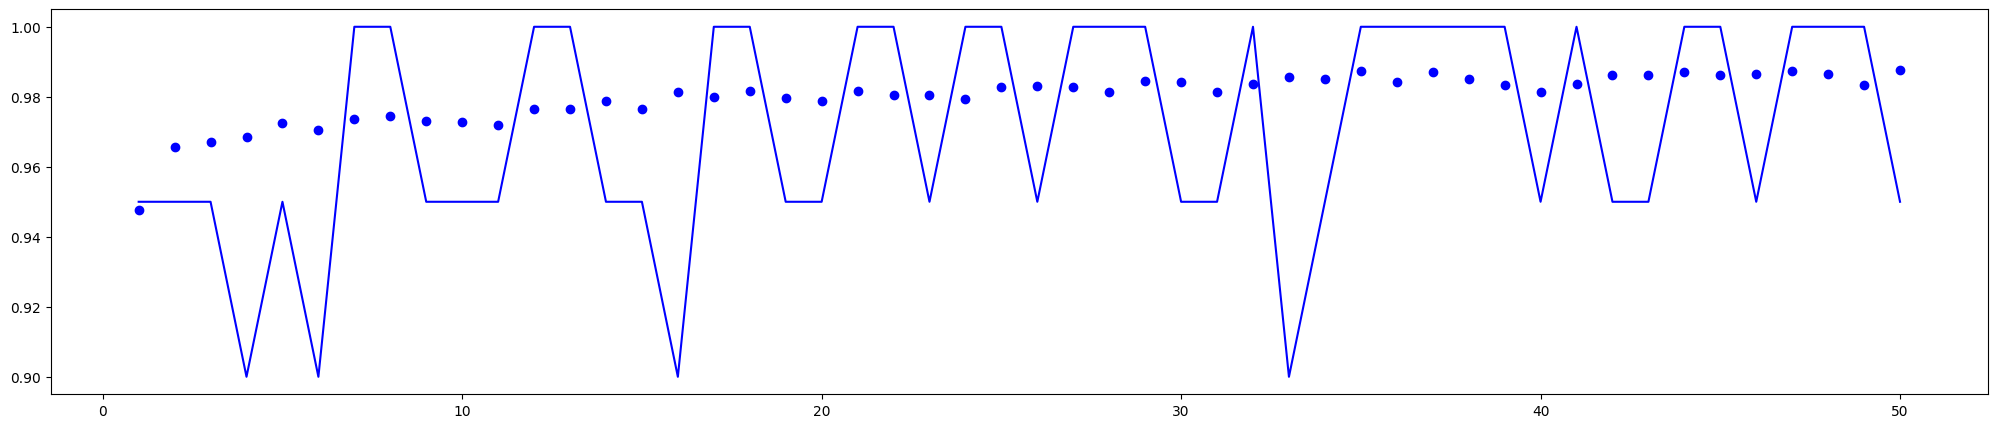

In [103]:
history1 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history1.items()}
plot_accuracy_from_history(history1)

## <a id='toc2_3_'></a>[Fine-Tuning method (slower but with augmentation)](#toc0_)

### <a id='toc2_3_1_'></a>[Prepare Data](#toc0_)

In [104]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # random horizontal flip
        transforms.RandomHorizontalFlip(),
        # random Linear Transformation
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir = 'kaggle/cats_and_dogs_small/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=True) for x in ['train', 'validation', 'test']}

### <a id='toc2_3_2_'></a>[Create model](#toc0_)

In [105]:
class ModelFineTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            nn.Flatten(0, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model2 = ModelFineTuning().to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model2.parameters(), lr=2e-5)

In [106]:
# Training loop
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    
    model2.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model2(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model2.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model2(inputs)
            val_loss = criterion(outputs, labels.float())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history2: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
}
    
    

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:39<00:00, 10.25it/s]


Epoch 1/50 Loss: 0.4452 Acc: 0.8346
Validation Loss: 0.2926 Acc: 0.9340


100%|██████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch 2/50 Loss: 0.3048 Acc: 0.8888
Validation Loss: 0.2127 Acc: 0.9370


100%|██████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch 3/50 Loss: 0.2674 Acc: 0.8949
Validation Loss: 0.1842 Acc: 0.9350


100%|██████████| 400/400 [00:38<00:00, 10.41it/s]


Epoch 4/50 Loss: 0.2468 Acc: 0.8974
Validation Loss: 0.1694 Acc: 0.9410


100%|██████████| 400/400 [00:39<00:00, 10.20it/s]


Epoch 5/50 Loss: 0.2254 Acc: 0.9079
Validation Loss: 0.1585 Acc: 0.9430


100%|██████████| 400/400 [00:41<00:00,  9.73it/s]


Epoch 6/50 Loss: 0.2180 Acc: 0.9080
Validation Loss: 0.1490 Acc: 0.9450


100%|██████████| 400/400 [00:40<00:00,  9.99it/s]


Epoch 7/50 Loss: 0.2078 Acc: 0.9140
Validation Loss: 0.1436 Acc: 0.9430


100%|██████████| 400/400 [00:39<00:00, 10.08it/s]


Epoch 8/50 Loss: 0.2092 Acc: 0.9093
Validation Loss: 0.1403 Acc: 0.9450


100%|██████████| 400/400 [00:39<00:00, 10.21it/s]


Epoch 9/50 Loss: 0.2060 Acc: 0.9094
Validation Loss: 0.1371 Acc: 0.9480


100%|██████████| 400/400 [00:39<00:00, 10.01it/s]


Epoch 10/50 Loss: 0.2089 Acc: 0.9110
Validation Loss: 0.1341 Acc: 0.9490


100%|██████████| 400/400 [00:39<00:00, 10.09it/s]


Epoch 11/50 Loss: 0.2020 Acc: 0.9145
Validation Loss: 0.1260 Acc: 0.9510


100%|██████████| 400/400 [00:39<00:00, 10.16it/s]


Epoch 12/50 Loss: 0.2026 Acc: 0.9156
Validation Loss: 0.1314 Acc: 0.9490


100%|██████████| 400/400 [00:39<00:00, 10.05it/s]


Epoch 13/50 Loss: 0.1996 Acc: 0.9155
Validation Loss: 0.1240 Acc: 0.9530


100%|██████████| 400/400 [00:37<00:00, 10.65it/s]


Epoch 14/50 Loss: 0.2003 Acc: 0.9138
Validation Loss: 0.1274 Acc: 0.9490


100%|██████████| 400/400 [00:38<00:00, 10.33it/s]


Epoch 15/50 Loss: 0.1986 Acc: 0.9176
Validation Loss: 0.1245 Acc: 0.9580


100%|██████████| 400/400 [00:38<00:00, 10.40it/s]


Epoch 16/50 Loss: 0.1989 Acc: 0.9166
Validation Loss: 0.1242 Acc: 0.9500


100%|██████████| 400/400 [00:38<00:00, 10.37it/s]


Epoch 17/50 Loss: 0.1923 Acc: 0.9208
Validation Loss: 0.1254 Acc: 0.9540


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Epoch 18/50 Loss: 0.1963 Acc: 0.9186
Validation Loss: 0.1188 Acc: 0.9520


100%|██████████| 400/400 [00:38<00:00, 10.26it/s]


Epoch 19/50 Loss: 0.1933 Acc: 0.9146
Validation Loss: 0.1253 Acc: 0.9510


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]


Epoch 20/50 Loss: 0.1904 Acc: 0.9184
Validation Loss: 0.1206 Acc: 0.9530


100%|██████████| 400/400 [00:38<00:00, 10.46it/s]


Epoch 21/50 Loss: 0.1829 Acc: 0.9233
Validation Loss: 0.1201 Acc: 0.9560


100%|██████████| 400/400 [00:42<00:00,  9.47it/s]


Epoch 22/50 Loss: 0.1772 Acc: 0.9253
Validation Loss: 0.1211 Acc: 0.9540


100%|██████████| 400/400 [00:44<00:00,  8.99it/s]


Epoch 23/50 Loss: 0.1918 Acc: 0.9160
Validation Loss: 0.1230 Acc: 0.9520


100%|██████████| 400/400 [00:42<00:00,  9.48it/s]


Epoch 24/50 Loss: 0.1900 Acc: 0.9196
Validation Loss: 0.1217 Acc: 0.9480


100%|██████████| 400/400 [00:41<00:00,  9.71it/s]


Epoch 25/50 Loss: 0.1904 Acc: 0.9190
Validation Loss: 0.1181 Acc: 0.9560


100%|██████████| 400/400 [00:38<00:00, 10.46it/s]


Epoch 26/50 Loss: 0.1941 Acc: 0.9208
Validation Loss: 0.1182 Acc: 0.9510


100%|██████████| 400/400 [00:37<00:00, 10.58it/s]


Epoch 27/50 Loss: 0.1886 Acc: 0.9193
Validation Loss: 0.1185 Acc: 0.9530


100%|██████████| 400/400 [00:37<00:00, 10.59it/s]


Epoch 28/50 Loss: 0.1813 Acc: 0.9225
Validation Loss: 0.1138 Acc: 0.9550


100%|██████████| 400/400 [00:38<00:00, 10.34it/s]


Epoch 29/50 Loss: 0.1752 Acc: 0.9271
Validation Loss: 0.1152 Acc: 0.9520


100%|██████████| 400/400 [00:37<00:00, 10.53it/s]


Epoch 30/50 Loss: 0.1888 Acc: 0.9208
Validation Loss: 0.1153 Acc: 0.9540


100%|██████████| 400/400 [00:38<00:00, 10.42it/s]


Epoch 31/50 Loss: 0.1765 Acc: 0.9249
Validation Loss: 0.1162 Acc: 0.9570


100%|██████████| 400/400 [00:38<00:00, 10.46it/s]


Epoch 32/50 Loss: 0.1799 Acc: 0.9224
Validation Loss: 0.1130 Acc: 0.9550


100%|██████████| 400/400 [00:42<00:00,  9.41it/s]


Epoch 33/50 Loss: 0.1853 Acc: 0.9195
Validation Loss: 0.1166 Acc: 0.9550


100%|██████████| 400/400 [00:46<00:00,  8.57it/s]


Epoch 34/50 Loss: 0.1784 Acc: 0.9254
Validation Loss: 0.1182 Acc: 0.9530


100%|██████████| 400/400 [00:47<00:00,  8.49it/s]


Epoch 35/50 Loss: 0.1789 Acc: 0.9225
Validation Loss: 0.1144 Acc: 0.9570


100%|██████████| 400/400 [00:48<00:00,  8.33it/s]


Epoch 36/50 Loss: 0.1804 Acc: 0.9268
Validation Loss: 0.1172 Acc: 0.9540


100%|██████████| 400/400 [00:47<00:00,  8.49it/s]


Epoch 37/50 Loss: 0.1775 Acc: 0.9225
Validation Loss: 0.1130 Acc: 0.9530


100%|██████████| 400/400 [00:46<00:00,  8.65it/s]


Epoch 38/50 Loss: 0.1801 Acc: 0.9225
Validation Loss: 0.1142 Acc: 0.9580


100%|██████████| 400/400 [00:43<00:00,  9.11it/s]


Epoch 39/50 Loss: 0.1820 Acc: 0.9211
Validation Loss: 0.1109 Acc: 0.9560


100%|██████████| 400/400 [00:38<00:00, 10.38it/s]


Epoch 40/50 Loss: 0.1778 Acc: 0.9248
Validation Loss: 0.1143 Acc: 0.9530


100%|██████████| 400/400 [00:38<00:00, 10.34it/s]


Epoch 41/50 Loss: 0.1772 Acc: 0.9219
Validation Loss: 0.1123 Acc: 0.9560


100%|██████████| 400/400 [00:38<00:00, 10.37it/s]


Epoch 42/50 Loss: 0.1746 Acc: 0.9256
Validation Loss: 0.1105 Acc: 0.9570


100%|██████████| 400/400 [00:39<00:00, 10.14it/s]


Epoch 43/50 Loss: 0.1837 Acc: 0.9196
Validation Loss: 0.1128 Acc: 0.9570


100%|██████████| 400/400 [00:38<00:00, 10.34it/s]


Epoch 44/50 Loss: 0.1764 Acc: 0.9270
Validation Loss: 0.1120 Acc: 0.9570


100%|██████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch 45/50 Loss: 0.1779 Acc: 0.9240
Validation Loss: 0.1095 Acc: 0.9590


100%|██████████| 400/400 [00:43<00:00,  9.29it/s]


Epoch 46/50 Loss: 0.1750 Acc: 0.9266
Validation Loss: 0.1110 Acc: 0.9590


100%|██████████| 400/400 [00:46<00:00,  8.56it/s]


Epoch 47/50 Loss: 0.1662 Acc: 0.9325
Validation Loss: 0.1103 Acc: 0.9550


100%|██████████| 400/400 [00:47<00:00,  8.46it/s]


Epoch 48/50 Loss: 0.1720 Acc: 0.9311
Validation Loss: 0.1121 Acc: 0.9560


100%|██████████| 400/400 [00:46<00:00,  8.66it/s]


Epoch 49/50 Loss: 0.1756 Acc: 0.9265
Validation Loss: 0.1093 Acc: 0.9600


100%|██████████| 400/400 [00:47<00:00,  8.42it/s]


Epoch 50/50 Loss: 0.1726 Acc: 0.9288
Validation Loss: 0.1124 Acc: 0.9550


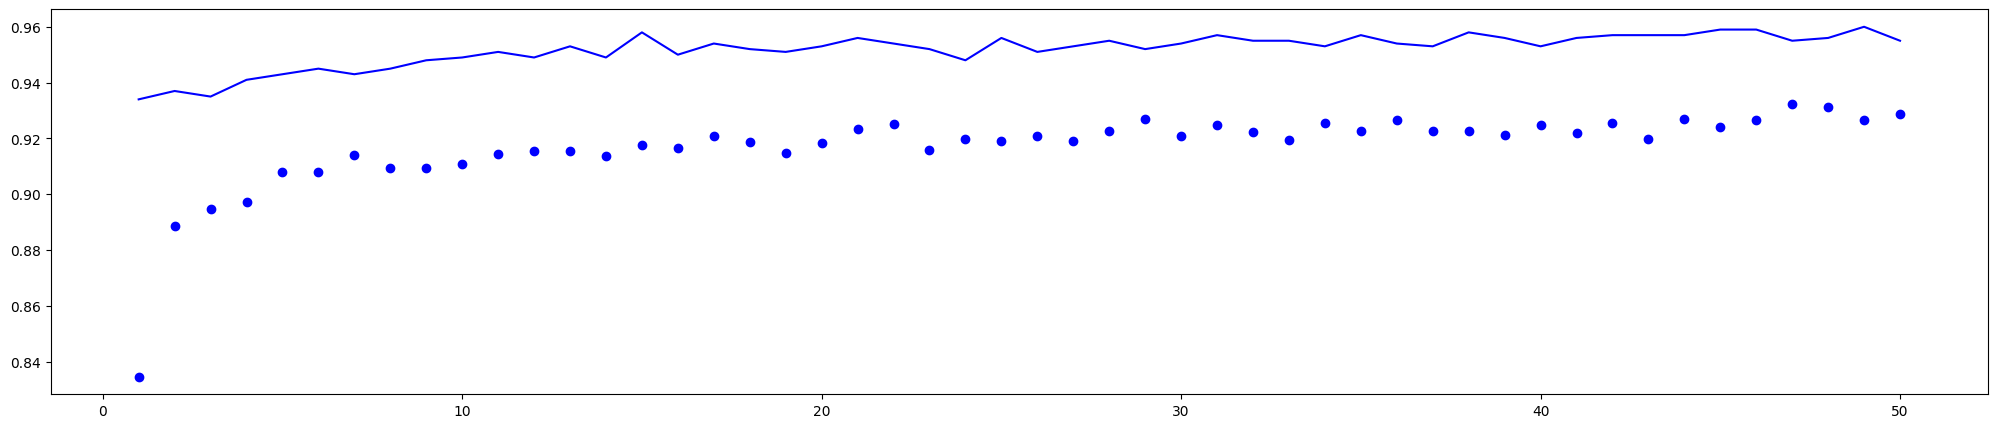

In [107]:
history2 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history2.items()}
plot_accuracy_from_history(history2)

# <a id='toc3_'></a>[Tuning Method (unfreeze few layers from ResNet)](#toc0_)

In [108]:
class ModelTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        for param in self.resnet.layer4.parameters(): # unfreeze the last layer
            param.requires_grad = True
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            nn.Flatten(0, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model3 = ModelTuning().to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model3.parameters(), lr=2e-5)

In [109]:
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    model3.train()
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train'], disable=True):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model3(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model3.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model3(inputs)
            val_loss = criterion(outputs, labels.float())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum((outputs > 0.5) == labels.byte())
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history3: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }

Epoch 1/50 Loss: 0.2119 Acc: 0.9234
Validation Loss: 0.1112 Acc: 0.9570
Epoch 2/50 Loss: 0.1369 Acc: 0.9453
Validation Loss: 0.1056 Acc: 0.9570
Epoch 3/50 Loss: 0.1207 Acc: 0.9541
Validation Loss: 0.0902 Acc: 0.9620
Epoch 4/50 Loss: 0.1043 Acc: 0.9566
Validation Loss: 0.0811 Acc: 0.9630
Epoch 5/50 Loss: 0.0940 Acc: 0.9616
Validation Loss: 0.0895 Acc: 0.9610
Epoch 6/50 Loss: 0.0919 Acc: 0.9661
Validation Loss: 0.0808 Acc: 0.9650
Epoch 7/50 Loss: 0.0778 Acc: 0.9695
Validation Loss: 0.0758 Acc: 0.9660
Epoch 8/50 Loss: 0.0763 Acc: 0.9729
Validation Loss: 0.0816 Acc: 0.9630
Epoch 9/50 Loss: 0.0719 Acc: 0.9744
Validation Loss: 0.0756 Acc: 0.9670
Epoch 10/50 Loss: 0.0585 Acc: 0.9790
Validation Loss: 0.0830 Acc: 0.9640
Epoch 11/50 Loss: 0.0621 Acc: 0.9766
Validation Loss: 0.0775 Acc: 0.9650
Epoch 12/50 Loss: 0.0608 Acc: 0.9778
Validation Loss: 0.0812 Acc: 0.9650
Epoch 13/50 Loss: 0.0489 Acc: 0.9833
Validation Loss: 0.1044 Acc: 0.9570
Epoch 14/50 Loss: 0.0472 Acc: 0.9823
Validation Loss: 0.0897

[array(0.92337507, dtype=float32), array(0.94525003, dtype=float32), array(0.95412505, dtype=float32), array(0.95662504, dtype=float32), array(0.96162504, dtype=float32), array(0.9661251, dtype=float32), array(0.96950006, dtype=float32), array(0.97287506, dtype=float32), array(0.97437507, dtype=float32), array(0.97900003, dtype=float32), array(0.976625, dtype=float32), array(0.97775006, dtype=float32), array(0.98325, dtype=float32), array(0.98225003, dtype=float32), array(0.98362505, dtype=float32), array(0.985625, dtype=float32), array(0.98850006, dtype=float32), array(0.98862505, dtype=float32), array(0.98937505, dtype=float32), array(0.989875, dtype=float32), array(0.99200004, dtype=float32), array(0.99087507, dtype=float32), array(0.989875, dtype=float32), array(0.9907501, dtype=float32), array(0.99000007, dtype=float32), array(0.99362504, dtype=float32), array(0.99112505, dtype=float32), array(0.99287504, dtype=float32), array(0.9915, dtype=float32), array(0.99462503, dtype=float3

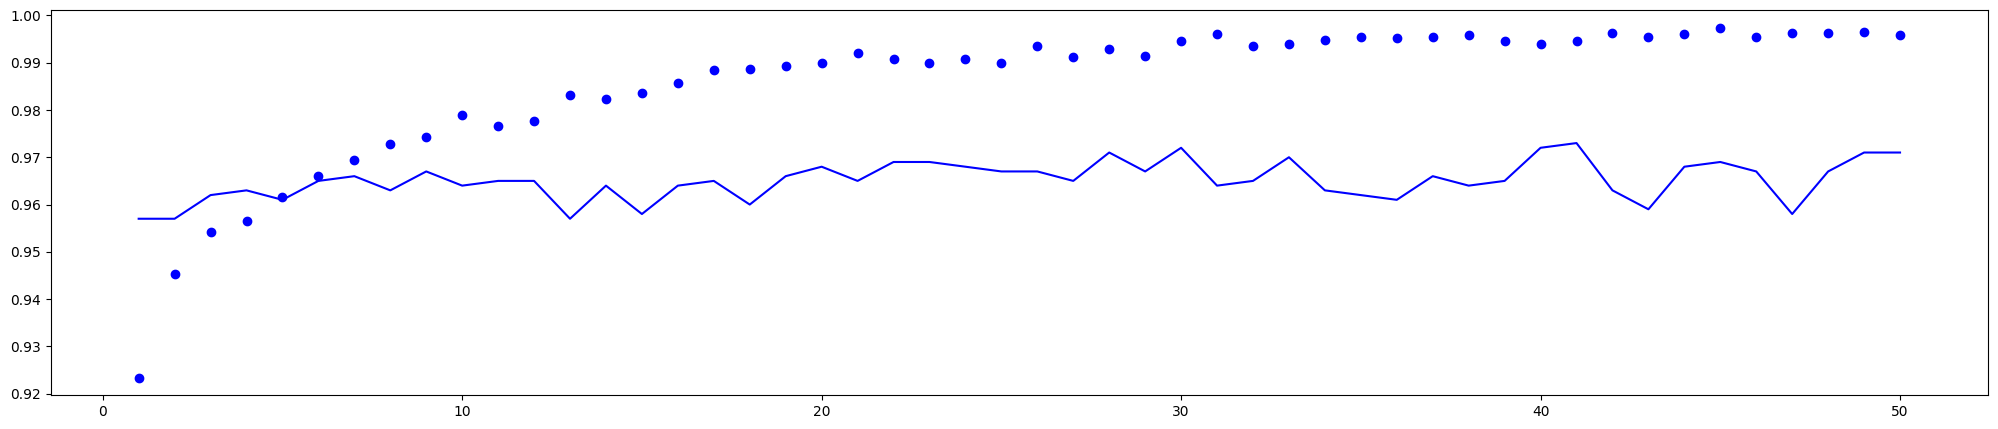

In [110]:
history3 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history3.items()}
plot_accuracy_from_history(history3)
print(history3['accuracy'])

# <a id='toc4_'></a>[Conclusion](#toc0_)

In this notebook, I decided in favour of reimplementing the entire thing in PyTorch for training purposes. Also, I quickly realised how advantageous the ResNet model is, so I decided to use it for feature extraction and fine-tuning. This obviously forced changes in all parameters, but the final result was worth it. I must say that an accuracy of 0.92 in the first epoch is a sight to behold.

Stuff I've learned:
- PyTorch practice
- ResNet (how it works, how to use it and it's advantages)
- Transfer Learning methods and their differences
- Data Augumentation in PyTorch